## Abstract:
We will be examining the Instacart Database and trying to acquire some valuable business insights out of this. And we will be trying answer three different questions relating to this database. 

Question 1: What kind of products are purchased and reordered the most? The importance of this question is that we get a sense of what the most popular products are as well as maybe gaining an understanding of the multiple skews that are at play. Furthermore, we can decipher which departments are individually doing the best and we can opt to direct more support to flagging departments as a result. 

Question 2: What factors influence one's decision to reorder a good and can we make a model that accurately predicts whether a good will be reordered? This is important because with this knowledge we can prepare our inventory based on the likleihood of a product being reordered in the future.Ideally we can shift our demand expectations to be closer in line with reality in general with the implementation of this. 

Question 3: What products are baskets similar to this one purchasing? Once we have a some idea about the purchasing habits of customers, we can create a system to find products they might like and furthemore we can reccommend those products to our customers. This can help further drive sales and show customers products they may want but didn't know we offered as well as goods they may not have known they needed. 

## O —  Obtaining our data: 
The Data was obtained from the Kaggle instacart dataset. 

## S — Scrubbing / Cleaning our data: 
The data is largely already pretty clean and required little modification before it was ready to use outside the box. 

## E — Exploring / Visualizing our data will allow us to find patterns and trends: 
Data Exploration Yeilded many very interesting insights. We very quickly learn that a tremendous amount of instacart's sales are from organic products. Considering that organic products tend to be pricier than the inorganic variety. We may consider the organic product as a large driver of revenues. We also get to see which departments are performing best and worst. We discover that produce, dairy, snacks, and beverages make up the contents of over 50 percent of all instacart orders. Furthermore, we discover that people tend to reorder more on weekly or monthly intervals. 

## M — Modeling our data will give us our predictive power as a wizard: 
We produce a model that helps us predict whether a certain good will be reordered or not. This is really useful because it helps us anticipate future demand. Another model we make helps us see what customers similar to this customer purchase. This can assist us in determining what the complementary goods of a certain product is. If the demand of X and Y covary together we can see what a decrease in the price of X may increase the demand of Y as well. 

## N — Interpreting our data: 
Our model has a 71% accuracy at predicting whether someone will or will not reorder a product. Our reccommendation system showed that whenever one is purchasing any kind of food product, it is probably good to reccommend to the consumer to purchase fresh fruit. Additionally, we got insights about very specific goods like what to reccommend when your customer purchases red wine (reccommend white wine!)

First We will just import all the libraries and the tables we need. 

In [164]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

plt.style.use('seaborn')
color = sns.color_palette()
%matplotlib inline

In [165]:
aisles=pd.read_csv('aisles.csv')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [166]:
len(aisles)

134

In [167]:
departments = pd.read_csv('departments.csv')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [168]:
len(departments)

21

In [169]:
prev_orders = pd.read_csv('order_products__prior.csv')
print(len(prev_orders))
prev_orders.head()

32434489


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [170]:
order_train = pd.read_csv('order_products__train.csv')
print(len(order_train))
order_train.head()

1384617


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [178]:
orders= pd.read_csv('orders.csv')
print(len(orders))
(orders.head())

3421083


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [172]:
len(orders.order_id.unique())

3421083

In [10]:
products = pd.read_csv('products.csv')
print(len(orders))
products.head()

3421083


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [11]:
products.describe()

,product_id,aisle_id,department_id
count,49688.000000,49688.000000,49688.000000
mean,24844.500000,67.769582,11.728687
std,14343.834425,38.316162,5.850410
min,1.000000,1.000000,1.000000
25%,12422.750000,35.000000,7.000000
50%,24844.500000,69.000000,13.000000
75%,37266.250000,100.000000,17.000000
max,49688.000000,134.000000,21.000000


In [12]:
products.product_id.unique()

array([    1,     2,     3, ..., 49686, 49687, 49688], dtype=int64)

In [13]:
len(products.product_id.unique())

49688

Let's examine just how many items people tend to buy at one time to get our bearings. 

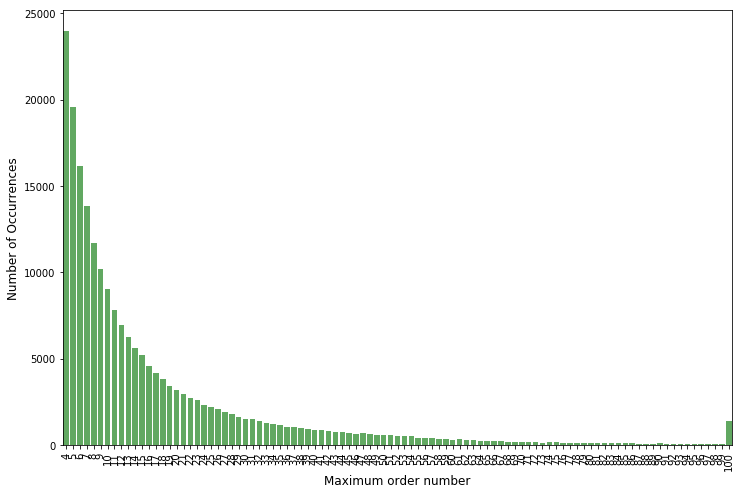

In [16]:
cnt_srs = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
cnt_srs = cnt_srs.order_number.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[2])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Here, we obviously see that most orders have less than ten orders to them. Next, let's see which days of the week have the greatest sales. 

In [184]:
orders.order_dow=orders.order_dow.replace([0,1,2,3,4,5,6], ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])

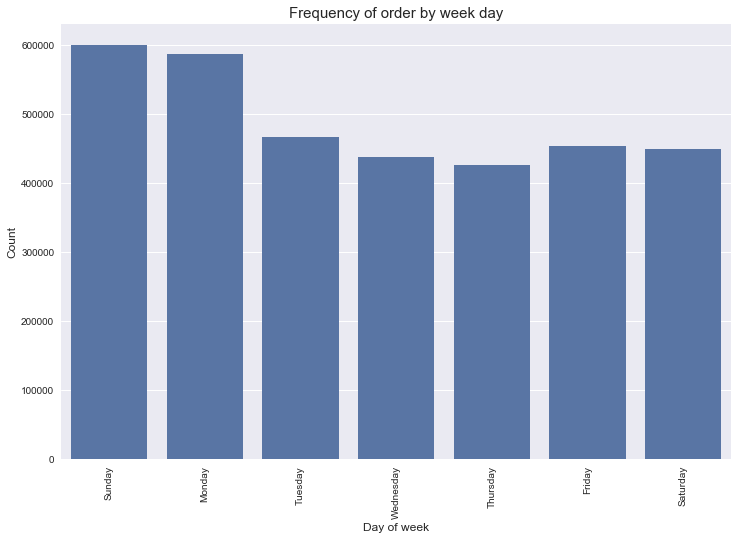

In [186]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders, color=color[0], order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by week day", fontsize=15)
plt.show()

It looks like Sunday and Monday are the most common days where orders are made, though, it is only slightly higher. How about looking at the times where orders were made? 


In [187]:
orders.order_hour_of_day=orders.order_hour_of_day.replace([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM', '12 PM', '1 PM', '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM'])

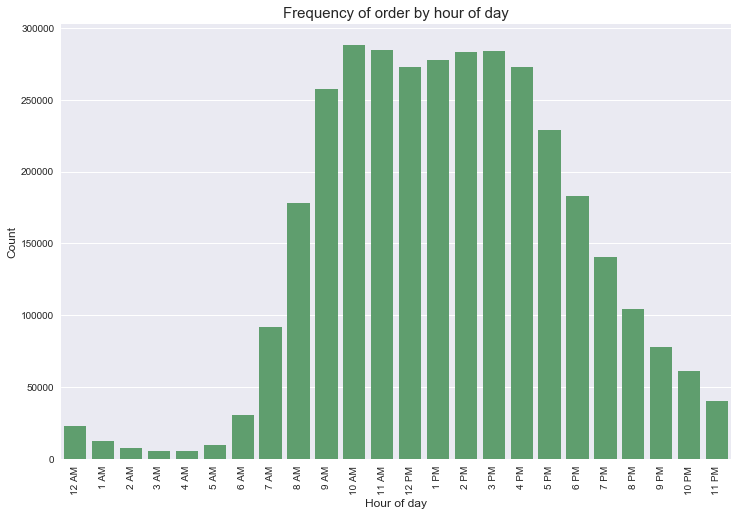

In [189]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders, color=color[1], order = ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM', '12 PM', '1 PM', '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM'])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of order by hour of day", fontsize=15)
plt.show()

Unsurprisingly, it doesn't seem like peopel are ordering many products in the dead of night and the fast majority appear to be made between 8 AM and 6 PM

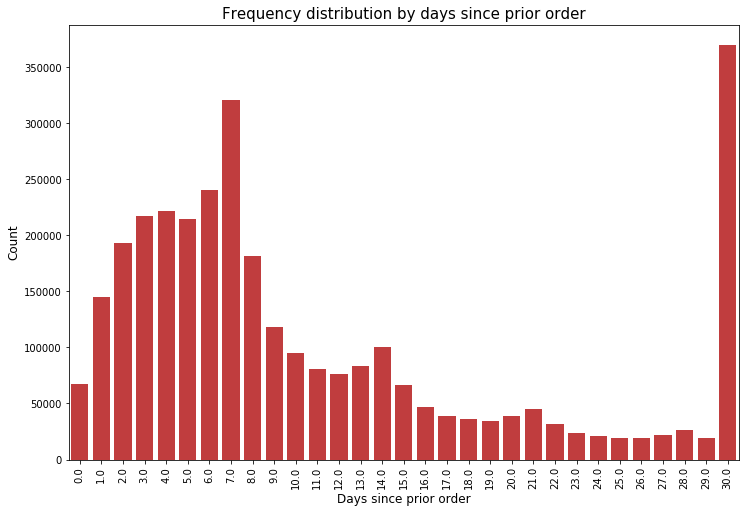

In [20]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders, color=color[3])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

We see that most orders are made within 10 days with notable spikes at 7, 14, and 30 days. 

In [21]:
prev_orders.reordered.sum() / prev_orders.shape[0]

0.5896974667922161

58% of users order more than once 

In [22]:
order_train.reordered.sum() / order_train.shape[0]


0.5985944127509629

In [23]:
grouped_df = prev_orders.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

C:\Users\xxtur\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [24]:
grouped_df = order_train.groupby("order_id")["reordered"].aggregate("sum").reset_index()
grouped_df["reordered"].ix[grouped_df["reordered"]>1] = 1
grouped_df.reordered.value_counts() / grouped_df.shape[0]

C:\Users\xxtur\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


1    0.93444
0    0.06556
Name: reordered, dtype: float64

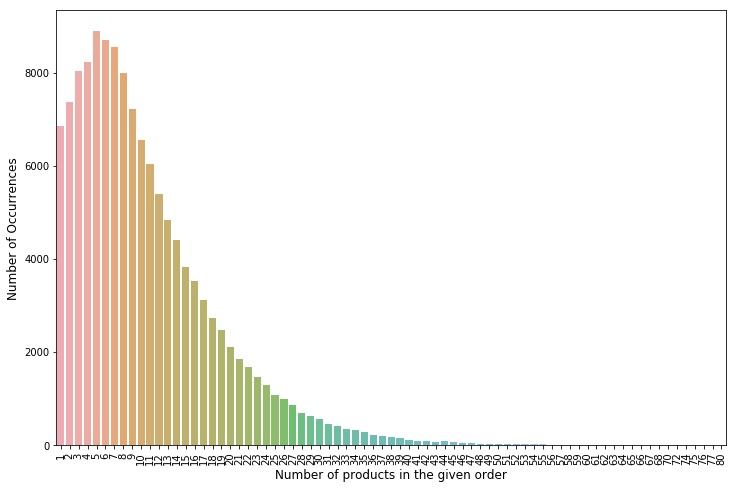

In [25]:
grouped_df = order_train.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of products in the given order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Let's merge our dataframes so we can do some further exploration and analysis. 

In [17]:
prev_orders = prev_orders.sample(frac=0.1, random_state=1)

In [18]:
prev_orders = pd.merge(prev_orders, products, on='product_id', how='left')

In [19]:
prev_orders.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1828726,11182,23,1,Baby Spinach,123,4
1,133158,17794,11,1,Carrots,83,4
2,1223705,30720,3,0,Sugar Snap Peas,83,4
3,2826286,19678,24,1,Organic Russet Potato,83,4
4,1883588,43713,9,0,Organic Creamy Peanut Butter,88,13


In [20]:
prev_orders = pd.merge(prev_orders, departments, on='department_id', how='left')
prev_orders.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department
0,1828726,11182,23,1,Baby Spinach,123,4,produce
1,133158,17794,11,1,Carrots,83,4,produce
2,1223705,30720,3,0,Sugar Snap Peas,83,4,produce
3,2826286,19678,24,1,Organic Russet Potato,83,4,produce
4,1883588,43713,9,0,Organic Creamy Peanut Butter,88,13,pantry


In [21]:
prev_orders = pd.merge(prev_orders, aisles, on='aisle_id', how='left')
prev_orders.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,1828726,11182,23,1,Baby Spinach,123,4,produce,packaged vegetables fruits
1,133158,17794,11,1,Carrots,83,4,produce,fresh vegetables
2,1223705,30720,3,0,Sugar Snap Peas,83,4,produce,fresh vegetables
3,2826286,19678,24,1,Organic Russet Potato,83,4,produce,fresh vegetables
4,1883588,43713,9,0,Organic Creamy Peanut Butter,88,13,pantry,spreads


In [22]:
len(prev_orders)

3243449

In [46]:
cnt_srs = prev_orders['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt_srs

,product_name,frequency_count
0,Banana,47060
1,Bag of Organic Bananas,37928
2,Organic Strawberries,26309
3,Organic Baby Spinach,24241
4,Organic Hass Avocado,21305
5,Organic Avocado,17792
6,Large Lemon,15366
7,Strawberries,14340
8,Limes,13888
9,Organic Whole Milk,13856


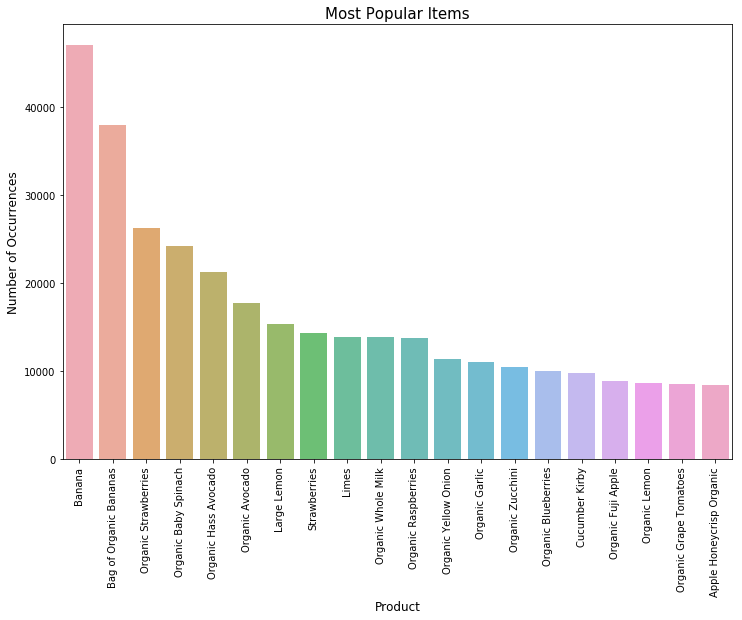

In [47]:
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs['product_name'].head(20), cnt_srs.frequency_count, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Most Popular Items", fontsize=15)
plt.show()

Here we can see that bananas and other organic products represet a very large portion of the most ordered products. Let's look and see if our reordered products are the same. 

In [49]:
all_order_products = prev_orders.loc[prev_orders['reordered'] == 1, 'product_id']
products_dict = pd.read_csv('products.csv')
print('Top reordered products are...')
product_counts = all_order_products.value_counts().reset_index()
product_counts.columns = ['product_id','reordered']
product_counts['share'] = product_counts['reordered'] / product_counts['reordered'].sum()
product_counts = product_counts.merge(products_dict[['product_id','product_name']], how='left', on='product_id')
product_counts.head(30)

Top reordered products are...


,product_id,reordered,share,product_name
0,24852,39713,0.020753,Banana
1,13176,31507,0.016465,Bag of Organic Bananas
2,21137,20497,0.010711,Organic Strawberries
3,21903,18835,0.009843,Organic Baby Spinach
4,47209,16943,0.008854,Organic Hass Avocado
5,47766,13488,0.007048,Organic Avocado
6,27845,11499,0.006009,Organic Whole Milk
7,47626,10751,0.005618,Large Lemon
8,27966,10711,0.005597,Organic Raspberries
9,16797,10020,0.005236,Strawberries


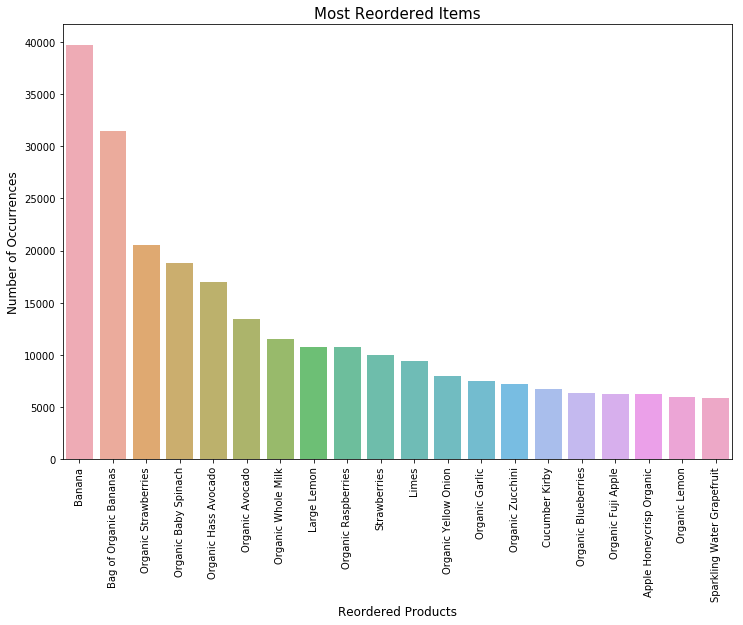

In [50]:
cnt_srs = product_counts['reordered'].head(20)
plt.figure(figsize=(12,8))
sns.barplot(product_counts['product_name'].head(20), cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Reordered Products', fontsize=12)
plt.title("Most Reordered Items", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

This is essentially the same list, just somewhat reordered. But let's look and see  what happens when we separate the organic and non organic products. 

In [36]:
cnt_srs.index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
            19],
           dtype='int64')

In [ ]:
cnt_srs = prev_orders['aisle'].value_counts().head(20)
plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[5])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

So It seems liek a very large proportion of ordered and reordered items are organic. It may be interesting to see if organic products are reordered at different rates. 

In [37]:
prev_orders['Organic'] = prev_orders['product_name'].str.contains('Organic').astype(int)

In [38]:
prev_orders

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle,Organic
0,1828726,11182,23,1,Baby Spinach,123,4,produce,packaged vegetables fruits,0
1,133158,17794,11,1,Carrots,83,4,produce,fresh vegetables,0
2,1223705,30720,3,0,Sugar Snap Peas,83,4,produce,fresh vegetables,0
3,2826286,19678,24,1,Organic Russet Potato,83,4,produce,fresh vegetables,1
4,1883588,43713,9,0,Organic Creamy Peanut Butter,88,13,pantry,spreads,1
5,1307143,33195,3,0,7 Sprouted Grains Bread,112,3,bakery,bread,0
6,2534787,27925,2,0,Organic Red Bartlett Pear,24,4,produce,fresh fruits,1
7,1548307,39984,8,0,Organic Dill,16,4,produce,fresh herbs,1
8,2770377,42553,2,1,Central Coast Cabernet Sauvignon,28,5,alcohol,red wines,0
9,2458684,48226,5,0,Select-A-Size White Giant Roll Paper Towels,54,17,household,paper goods,0


In [39]:
all_order_products_organic = prev_orders.loc[prev_orders['reordered'] == 1]
all_order_products_organic = all_order_products_organic.loc[all_order_products_organic['Organic']==1, 'product_id']

In [40]:
#all_order_products_organic = prev_orders.loc[prev_orders['reordered'] == 1, 'product_id']
#all_order_products_organic = prev_orders.loc[prev_orders['Organic'] == 1, 'product_id']
#all_order_products_organic = all_order_products_organic.loc[all_order_products_organic['Organic']==1]
products_dict = pd.read_csv('products.csv')
print('Top reordered organic products are...')
product_counts = all_order_products_organic.value_counts().reset_index()
product_counts.columns = ['product_id','reordered']
product_counts['share'] = product_counts['reordered'] / product_counts['reordered'].sum()
product_counts = product_counts.merge(products_dict[['product_id','product_name']], how='left', on='product_id')
product_counts.head(30)

Top reordered organic products are...


,product_id,reordered,share,product_name
0,13176,31507,0.048369,Bag of Organic Bananas
1,21137,20497,0.031466,Organic Strawberries
2,21903,18835,0.028915,Organic Baby Spinach
3,47209,16943,0.026010,Organic Hass Avocado
4,47766,13488,0.020706,Organic Avocado
5,27845,11499,0.017653,Organic Whole Milk
6,27966,10711,0.016443,Organic Raspberries
7,22935,7952,0.012208,Organic Yellow Onion
8,24964,7533,0.011564,Organic Garlic
9,45007,7239,0.011113,Organic Zucchini


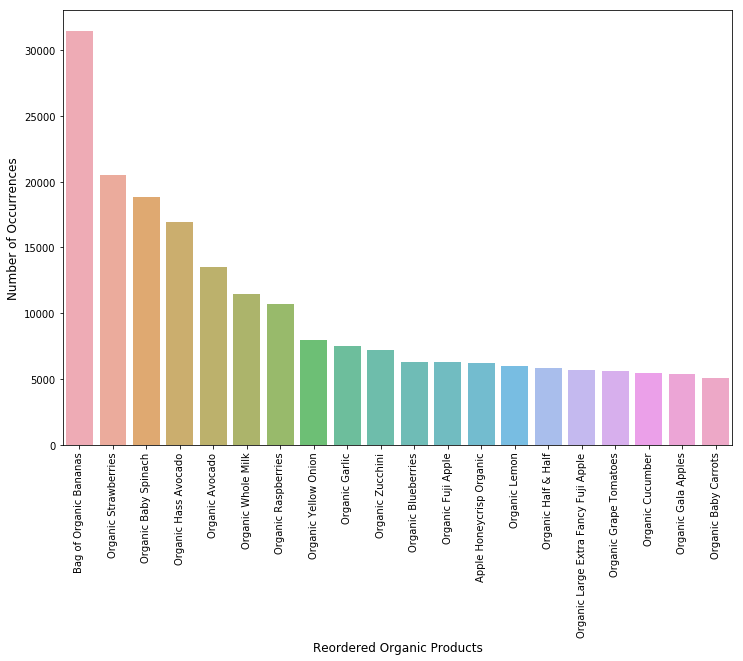

In [41]:
cnt_srs = product_counts['reordered'].head(20)
plt.figure(figsize=(12,8))
sns.barplot(product_counts['product_name'].head(20), cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Reordered Organic Products', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [ ]:
cnt_srs = product_counts['reordered'].head(20)
plt.figure(figsize=(12,8))
sns.barplot(product_counts['product_name'].head(20), cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [42]:
all_order_products_organic = prev_orders.loc[prev_orders['reordered'] == 1]
all_order_products_organic = all_order_products_organic.loc[all_order_products_organic['Organic']==0, 'product_id']
print('Top reordered non-organic products are...')
product_counts = all_order_products_organic.value_counts().reset_index()
product_counts.columns = ['product_id','reordered']
product_counts['share'] = product_counts['reordered'] / product_counts['reordered'].sum()
product_counts = product_counts.merge(products_dict[['product_id','product_name']], how='left', on='product_id')
product_counts.head(30)

Top reordered non-organic products are...


,product_id,reordered,share,product_name
0,24852,39713,0.031463,Banana
1,47626,10751,0.008518,Large Lemon
2,16797,10020,0.007938,Strawberries
3,26209,9448,0.007485,Limes
4,49683,6723,0.005326,Cucumber Kirby
5,44632,5859,0.004642,Sparkling Water Grapefruit
6,45066,5841,0.004628,Honeycrisp Apple
7,4920,5503,0.004360,Seedless Red Grapes
8,27086,5220,0.004136,Half & Half
9,30489,5064,0.004012,Original Hummus


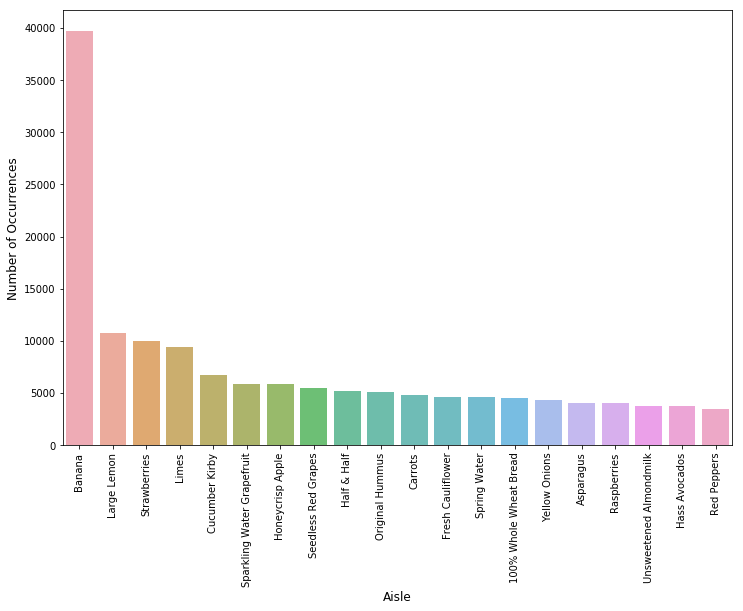

In [43]:
cnt_srs = product_counts['reordered'].head(20)
plt.figure(figsize=(12,8))
sns.barplot(product_counts['product_name'].head(20), cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Aisle', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

The only thing of tremendous note is the fact that Bananas are 4x as popular as anything as even the second most popular products. Now let's look at what departments sell the most products. 

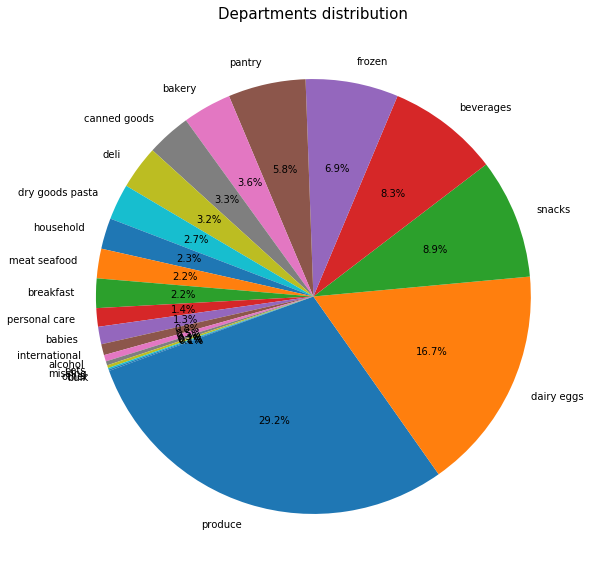

In [128]:
plt.figure(figsize=(10,10))
temp_series = prev_orders['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()

The vast majority of goods purchased are related to food products, which isn't surprising because you constantly have to order fresh goods like produce and Dairy eggs as they go bad. 

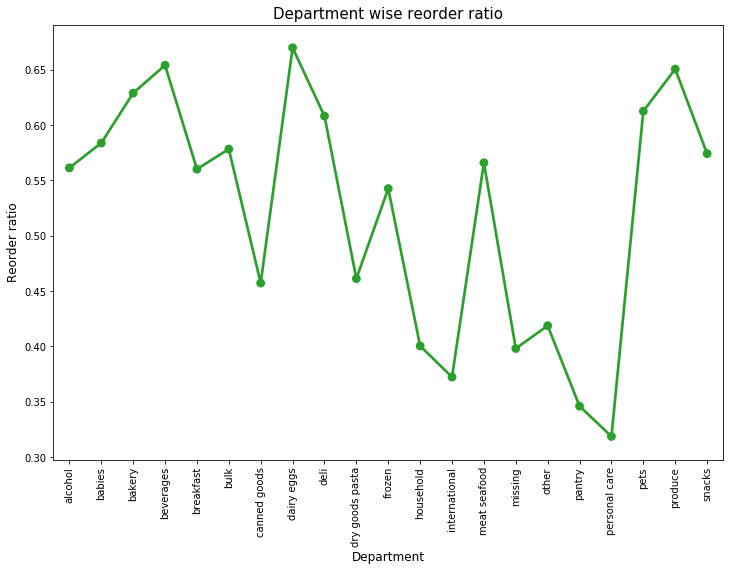

In [129]:
grouped_df = prev_orders.groupby(["department"])["reordered"].aggregate("mean").reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['department'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Department', fontsize=12)
plt.title("Department wise reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

We see here that personal care products as well as international products are very unlikely to be reordered.

In [130]:
grouped_df = prev_orders.groupby(["department_id", "aisle"])["reordered"].aggregate("mean").reset_index()

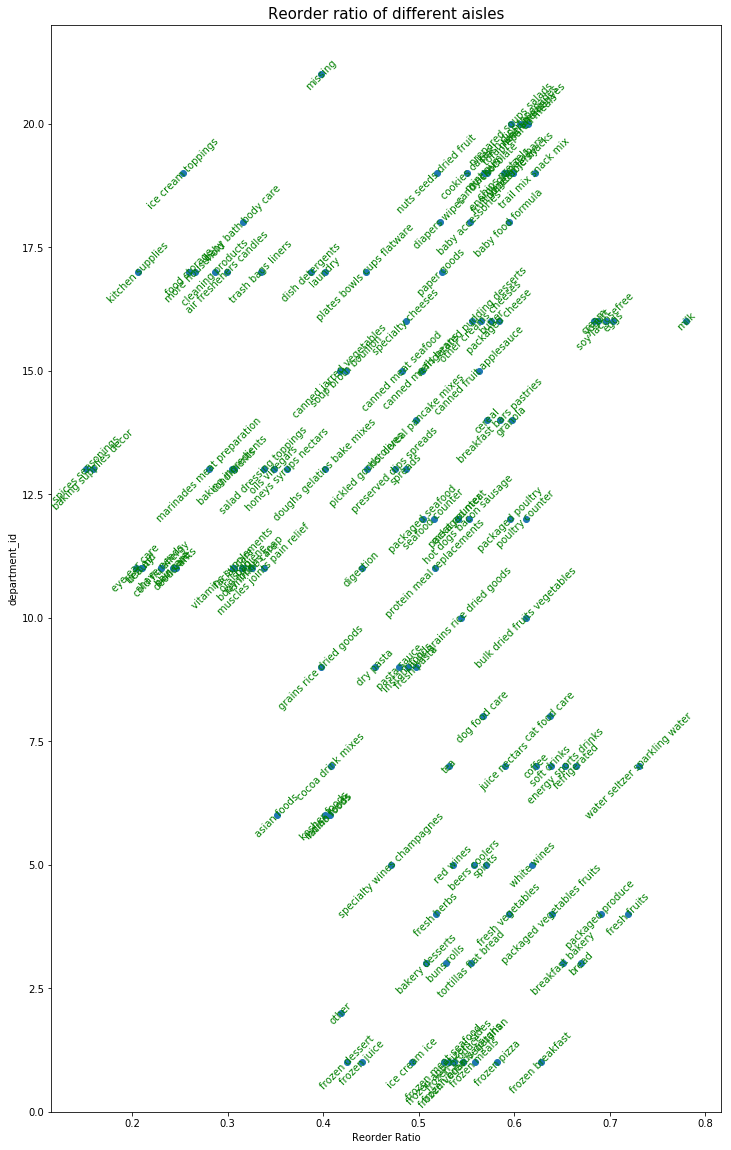

In [131]:
fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(grouped_df.reordered.values, grouped_df.department_id.values)
for i, txt in enumerate(grouped_df.aisle.values):
    ax.annotate(txt, (grouped_df.reordered.values[i], grouped_df.department_id.values[i]), rotation=45, ha='center', va='center', color='green')
plt.xlabel('Reorder Ratio')
plt.ylabel('department_id')
plt.title("Reorder ratio of different aisles", fontsize=15)
plt.show()

Here's a fun though maybe not terribly illuminating graph about what departments of goods are reordered most often. 

In [132]:
prev_orders["add_to_cart_order_mod"] = prev_orders["add_to_cart_order"].copy()
prev_orders["add_to_cart_order_mod"].ix[prev_orders["add_to_cart_order_mod"]>70] = 70
grouped_df = prev_orders.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

C:\Users\xxtur\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Users\xxtur\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


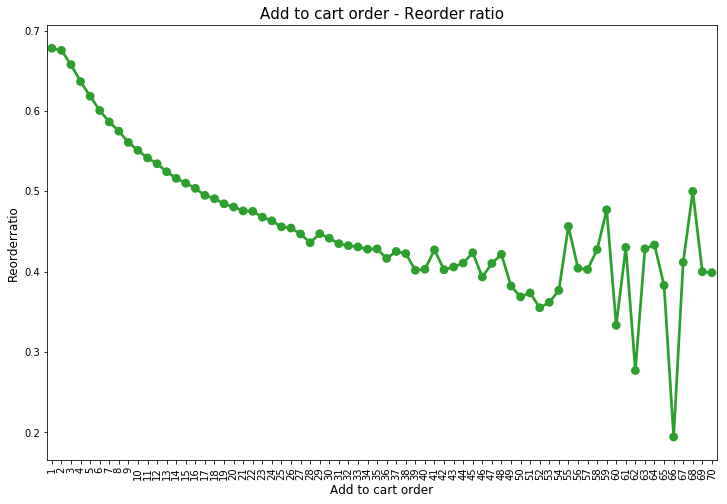

In [133]:
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df['add_to_cart_order_mod'].values, grouped_df['reordered'].values, alpha=0.8, color=color[2])
plt.ylabel('Reorderratio', fontsize=12)
plt.xlabel('Add to cart order', fontsize=12)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()


Here we see that the later a product is ordered in the order chain, the less likely it is to be ordered. The only exception is at the far end where people just aren't ordering that many products. 

In [24]:
prev_orders = pd.merge(prev_orders, orders, on='order_id', how='left')

In [25]:
prev_orders.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1828726,11182,23,1,Baby Spinach,123,4,produce,packaged vegetables fruits,91905,prior,26,0,9,5.0
1,133158,17794,11,1,Carrots,83,4,produce,fresh vegetables,187611,prior,10,5,9,10.0
2,1223705,30720,3,0,Sugar Snap Peas,83,4,produce,fresh vegetables,97846,prior,33,4,9,3.0
3,2826286,19678,24,1,Organic Russet Potato,83,4,produce,fresh vegetables,96241,prior,21,4,10,14.0
4,1883588,43713,9,0,Organic Creamy Peanut Butter,88,13,pantry,spreads,35097,prior,5,6,12,16.0


In [135]:
grouped_df = prev_orders.groupby(["order_dow"])["reordered"].aggregate("mean").reset_index()


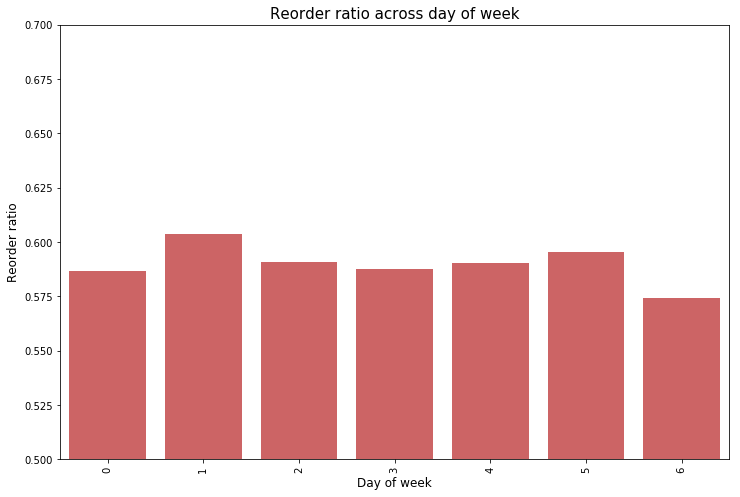

In [136]:
plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_dow'].values, grouped_df['reordered'].values, alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Reorder ratio across day of week", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

In [137]:
grouped_df = prev_orders.groupby(["order_hour_of_day"])["reordered"].aggregate("mean").reset_index()

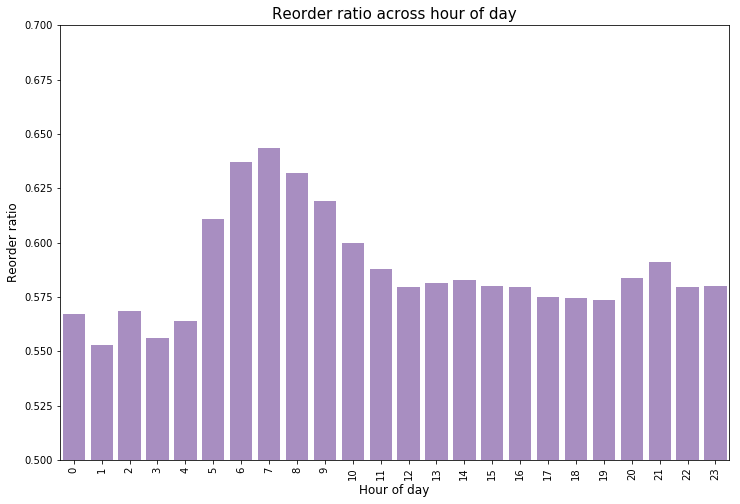

In [138]:
plt.figure(figsize=(12,8))
sns.barplot(grouped_df['order_hour_of_day'].values, grouped_df['reordered'].values, alpha=0.8, color=color[4])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("Reorder ratio across hour of day", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylim(0.5, 0.7)
plt.show()

The reorder ratio seems to be highest between 5 and 9 AM. People may be reordering at the beginning of the day, it may be beneficial to advertize morning products like coffee and toothpaste during these hours. 

Now that we've done our data exploration, we can work on predicting whether it is possible to predict whether a certain product will be reordered or not with machine learning. First, we select our variables.

In [35]:
df = prev_orders[['reordered', 'product_id', 'aisle_id', 'department_id', 'add_to_cart_order', 'order_hour_of_day', 'days_since_prior_order', 'order_number', 'order_dow']]
df.head()

,reordered,product_id,aisle_id,department_id,add_to_cart_order,order_hour_of_day,days_since_prior_order,order_number,order_dow
0,1,11182,123,4,23,9,5.0,26,0
1,1,17794,83,4,11,9,10.0,10,5
2,0,30720,83,4,3,9,3.0,33,4
3,1,19678,83,4,24,10,14.0,21,4
4,0,43713,88,13,9,12,16.0,5,6


In [38]:
y = df['reordered']
y.head()

0    1
1    1
2    0
3    1
4    0
Name: reordered, dtype: int64

In [39]:
unprocessed_X = df.drop(['reordered'], axis=1)

In [ ]:
unprocessed_X.head()

In [ ]:
unprocessed_X.info()

In [43]:
unprocessed_X.isna().sum()

product_id                0
aisle_id                  0
department_id             0
add_to_cart_order         0
order_hour_of_day         0
days_since_prior_order    0
order_number              0
order_dow                 0
dtype: int64

In [41]:
unprocessed_X=unprocessed_X.fillna(0)

In [42]:
unprocessed_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3243449 entries, 0 to 3243448
Data columns (total 8 columns):
product_id                int64
aisle_id                  int64
department_id             int64
add_to_cart_order         int64
order_hour_of_day         int64
days_since_prior_order    float64
order_number              int64
order_dow                 int64
dtypes: float64(1), int64(7)
memory usage: 222.7 MB


In [44]:
from sklearn.model_selection import train_test_split                                                                
X_train, X_test, y_train, y_test = train_test_split(unprocessed_X,y, test_size=.25)                                 

First we will try out a simple linear regression. 

In [45]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=0)
classifier.fit(X_train, y_train)

C:\Users\xxtur\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [46]:
preds = classifier.predict(X_test)
preds

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [47]:
def show_cf(y_true, y_pred, class_names=None, model_name=None):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    if model_name:
        plt.title("Confusion Matrix: {}".format(model_name))
    else:
        plt.title("Confusion Matrix")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(y_true)
    tick_marks = np.arange(len(class_names))
    if class_names:
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

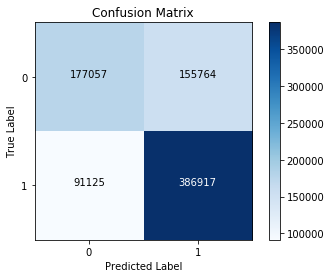

In [48]:
import itertools
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, preds)
show_cf(y_test, preds)

In [49]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.66      0.53      0.59    332821
           1       0.71      0.81      0.76    478042

   micro avg       0.70      0.70      0.70    810863
   macro avg       0.69      0.67      0.67    810863
weighted avg       0.69      0.70      0.69    810863



In [50]:
print(accuracy_score(y_test, preds))

0.695523164825624


The accuracy is okay, but I think we can improve on it. Let's try using more sophisticated classifiers and see where we get. First with a Decision Tree Classifier. 

In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
tree_clf = DecisionTreeClassifier(criterion = 'gini', max_depth=5)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [60]:
tree_pred = tree_clf.predict(X_test)

In [61]:
print(classification_report(y_test, tree_pred))

              precision    recall  f1-score   support

           0       0.69      0.56      0.62    332700
           1       0.73      0.82      0.77    478163

   micro avg       0.71      0.71      0.71    810863
   macro avg       0.71      0.69      0.69    810863
weighted avg       0.71      0.71      0.71    810863



In [62]:
print(accuracy_score(y_test, tree_pred))

0.7144067493522334


We can plot feature importances to see which has the most impact. 

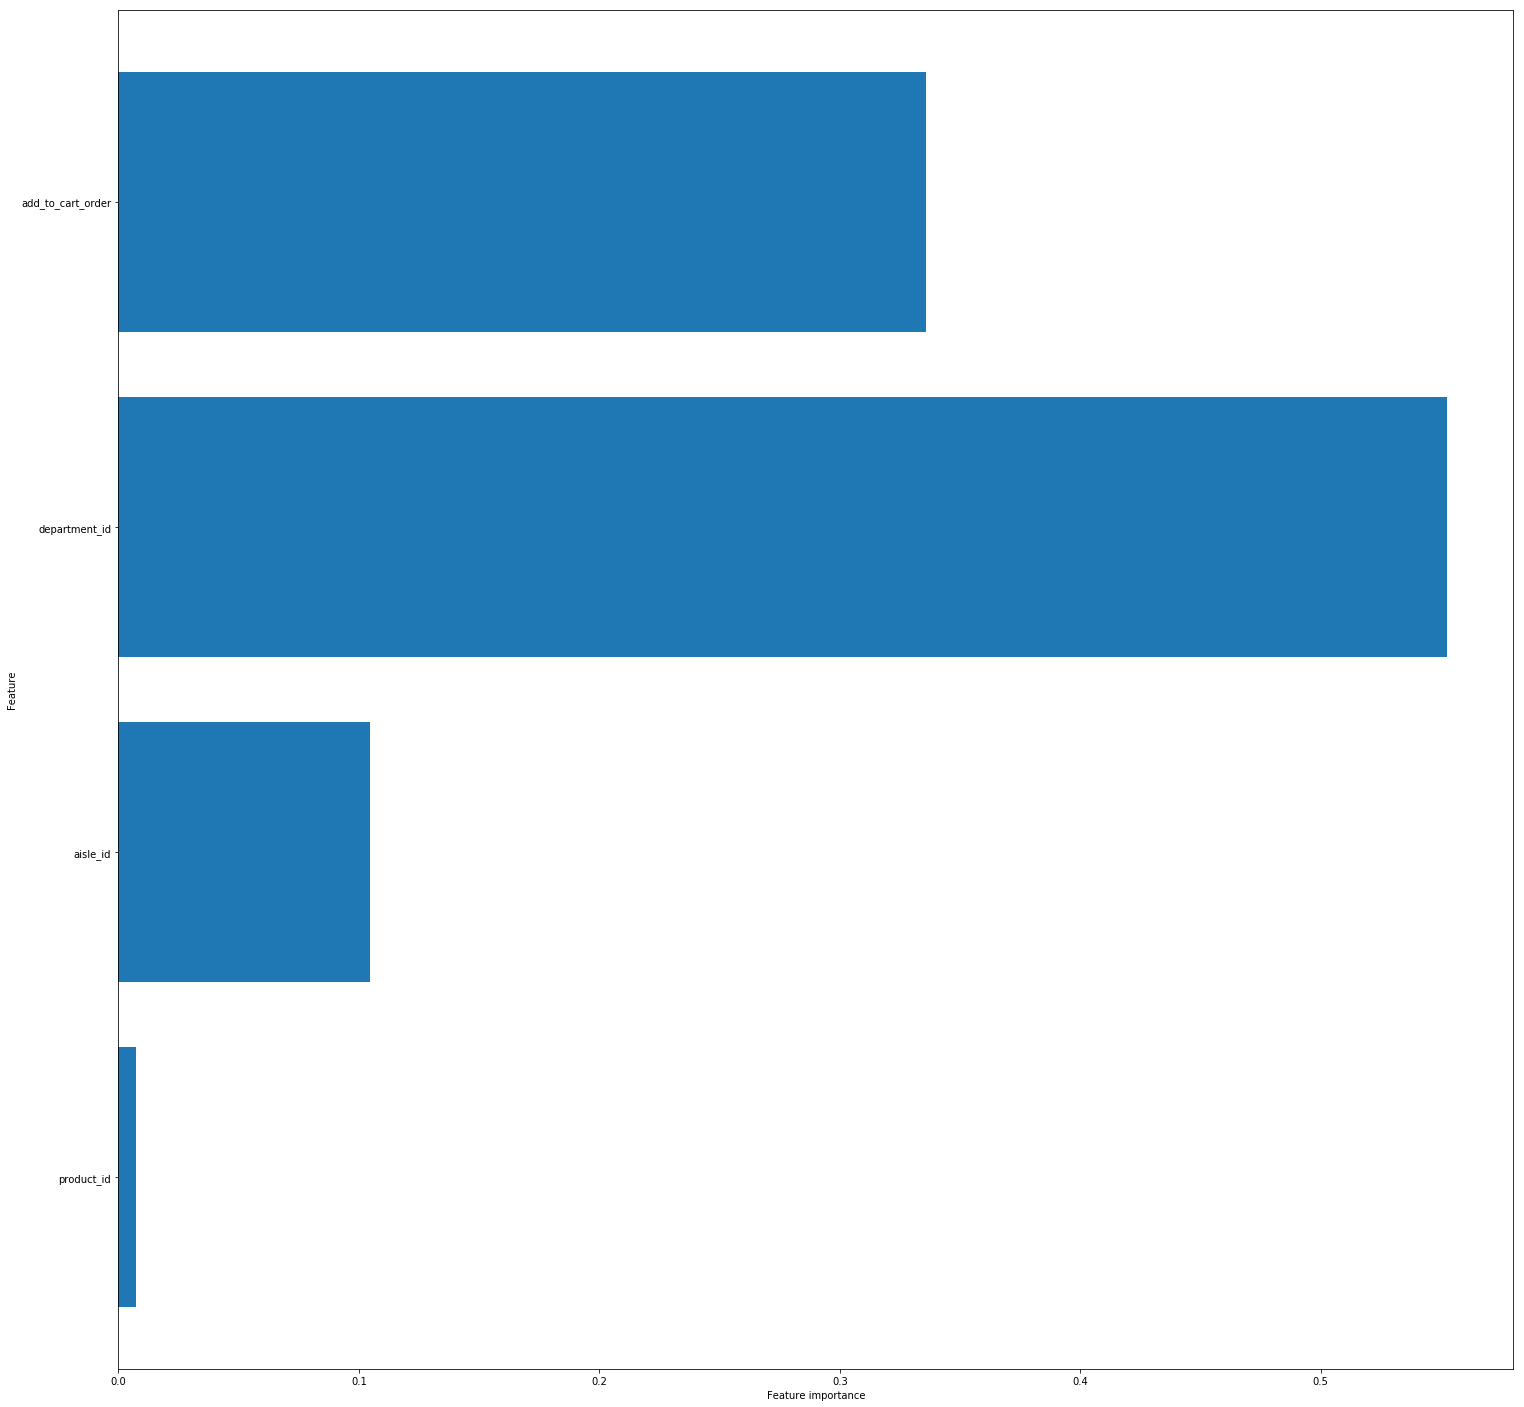

In [103]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(25,25))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), unprocessed_X.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

plot_feature_importances(tree_clf)

It looks like the department where the product is from has a large impact on how likely it is to be reordered. Let's see if our performance increases any with a random forest. 

In [68]:
forest = RandomForestClassifier(n_estimators=100, max_depth=5)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [69]:
forest.score(X_train, y_train)

0.7175191339586761

In [70]:
forest.score(X_test, y_test)

0.7172481664596856

In [71]:
f_pred =forest.predict(X_test)

In [72]:
print(accuracy_score(f_pred, y_test))
print(confusion_matrix(y_test, f_pred))
print(classification_report(y_test, f_pred))

0.7172481664596856
[[153733 178967]
 [ 50306 427857]]
              precision    recall  f1-score   support

           0       0.75      0.46      0.57    332700
           1       0.71      0.89      0.79    478163

   micro avg       0.72      0.72      0.72    810863
   macro avg       0.73      0.68      0.68    810863
weighted avg       0.72      0.72      0.70    810863



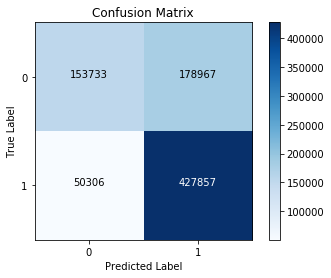

In [73]:
show_cf(y_test, f_pred)

Random forest boasts a miniscule improvement over a decision tree classifier. XGBoost is known for often outperforming Random forest. Perhaps we can put that to use here? 

In [51]:
import xgboost as xgb
xg_clf = xgb.XGBClassifier()
xg_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [52]:
xg_preds = xg_clf.predict(X_test)

In [53]:
print(accuracy_score(xg_preds, y_test))
print(confusion_matrix(y_test, xg_preds))
print(classification_report(y_test, xg_preds))

0.7295868722583223
[[176452 156369]
 [ 62899 415143]]
              precision    recall  f1-score   support

           0       0.74      0.53      0.62    332821
           1       0.73      0.87      0.79    478042

   micro avg       0.73      0.73      0.73    810863
   macro avg       0.73      0.70      0.70    810863
weighted avg       0.73      0.73      0.72    810863



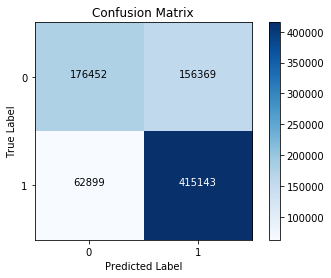

In [54]:
show_cf(y_test, xg_preds)

It appears that XGBoost also provides a modest improvement over random forest. We've increased our accuracy by approximately 3%. 

In [26]:
prev_orders.to_csv('prev_orders.csv')

In [10]:
import pandas as pd
prev_orders=pd.read_csv('prev_orders.csv')

In [11]:
prev_orders.head()

,Unnamed: 0,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,0,1828726,11182,23,1,Baby Spinach,123,4,produce,packaged vegetables fruits,91905,prior,26,0,9,5.0
1,1,133158,17794,11,1,Carrots,83,4,produce,fresh vegetables,187611,prior,10,5,9,10.0
2,2,1223705,30720,3,0,Sugar Snap Peas,83,4,produce,fresh vegetables,97846,prior,33,4,9,3.0
3,3,2826286,19678,24,1,Organic Russet Potato,83,4,produce,fresh vegetables,96241,prior,21,4,10,14.0
4,4,1883588,43713,9,0,Organic Creamy Peanut Butter,88,13,pantry,spreads,35097,prior,5,6,12,16.0


In [26]:
from collections import defaultdict
from collections import Counter

Let's go ahead and recreate prev_orders for this

In [12]:
orders = orders.sample(10000, random_state=1)

In [13]:
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1825071,2328908,109604,prior,5,3,9,30.0
2030859,813642,122003,prior,14,3,9,4.0
2022225,1222338,121483,prior,13,2,15,5.0
1812260,1947706,108833,prior,25,5,22,5.0
2820478,2190161,170174,prior,34,5,8,7.0
3369177,1544345,203062,prior,1,0,17,NaN
1669521,1672561,100231,prior,4,5,9,7.0
344707,2152491,20856,prior,3,1,16,30.0
1450601,3297788,87153,prior,7,3,14,2.0
2138644,3036676,128631,prior,6,2,12,5.0


In [14]:
len(orders.order_id.unique())

10000

In [15]:
prev_orders = pd.merge(prev_orders, orders, on='order_id', how='inner')

In [16]:
prev_orders

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,827,21903,1,0,71113,prior,1,3,8,NaN
1,827,48577,2,0,71113,prior,1,3,8,NaN
2,827,42701,3,0,71113,prior,1,3,8,NaN
3,930,19675,1,1,106143,prior,24,6,12,4.0
4,2301,4639,1,1,44250,prior,11,3,10,5.0
5,2301,32455,2,1,44250,prior,11,3,10,5.0
6,2301,49235,3,1,44250,prior,11,3,10,5.0
7,2301,27845,4,1,44250,prior,11,3,10,5.0
8,2301,30827,5,1,44250,prior,11,3,10,5.0
9,2301,12341,6,1,44250,prior,11,3,10,5.0


In [17]:
prev_orders = pd.merge(prev_orders, products, on='product_id', how='left')

In [18]:
prev_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id
0,827,21903,1,0,71113,prior,1,3,8,NaN,Organic Baby Spinach,123,4
1,827,48577,2,0,71113,prior,1,3,8,NaN,Cream Top Smooth Coffee Yogurt,120,16
2,827,42701,3,0,71113,prior,1,3,8,NaN,Organic Sour Cream,108,16
3,930,19675,1,1,106143,prior,24,6,12,4.0,Organic Raspberry Black Tea,94,7
4,2301,4639,1,1,44250,prior,11,3,10,5.0,Crumbled Bacon,89,13


In [19]:
prev_orders = pd.merge(prev_orders, departments, on='department_id', how='left')
prev_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department
0,827,21903,1,0,71113,prior,1,3,8,NaN,Organic Baby Spinach,123,4,produce
1,827,48577,2,0,71113,prior,1,3,8,NaN,Cream Top Smooth Coffee Yogurt,120,16,dairy eggs
2,827,42701,3,0,71113,prior,1,3,8,NaN,Organic Sour Cream,108,16,dairy eggs
3,930,19675,1,1,106143,prior,24,6,12,4.0,Organic Raspberry Black Tea,94,7,beverages
4,2301,4639,1,1,44250,prior,11,3,10,5.0,Crumbled Bacon,89,13,pantry


In [20]:
prev_orders = pd.merge(prev_orders, aisles, on='aisle_id', how='left')
prev_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,827,21903,1,0,71113,prior,1,3,8,NaN,Organic Baby Spinach,123,4,produce,packaged vegetables fruits
1,827,48577,2,0,71113,prior,1,3,8,NaN,Cream Top Smooth Coffee Yogurt,120,16,dairy eggs,yogurt
2,827,42701,3,0,71113,prior,1,3,8,NaN,Organic Sour Cream,108,16,dairy eggs,other creams cheeses
3,930,19675,1,1,106143,prior,24,6,12,4.0,Organic Raspberry Black Tea,94,7,beverages,tea
4,2301,4639,1,1,44250,prior,11,3,10,5.0,Crumbled Bacon,89,13,pantry,salad dressing toppings


In [21]:
prev_orders

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,827,21903,1,0,71113,prior,1,3,8,NaN,Organic Baby Spinach,123,4,produce,packaged vegetables fruits
1,827,48577,2,0,71113,prior,1,3,8,NaN,Cream Top Smooth Coffee Yogurt,120,16,dairy eggs,yogurt
2,827,42701,3,0,71113,prior,1,3,8,NaN,Organic Sour Cream,108,16,dairy eggs,other creams cheeses
3,930,19675,1,1,106143,prior,24,6,12,4.0,Organic Raspberry Black Tea,94,7,beverages,tea
4,2301,4639,1,1,44250,prior,11,3,10,5.0,Crumbled Bacon,89,13,pantry,salad dressing toppings
5,2301,32455,2,1,44250,prior,11,3,10,5.0,Whole Grain Cheddar Baked Snack Crackers,78,19,snacks,crackers
6,2301,49235,3,1,44250,prior,11,3,10,5.0,Organic Half & Half,53,16,dairy eggs,cream
7,2301,27845,4,1,44250,prior,11,3,10,5.0,Organic Whole Milk,84,16,dairy eggs,milk
8,2301,30827,5,1,44250,prior,11,3,10,5.0,Seedless Cucumbers,32,4,produce,packaged produce
9,2301,12341,6,1,44250,prior,11,3,10,5.0,Hass Avocados,32,4,produce,packaged produce


In [22]:
len(prev_orders.user_id.unique())

8974

In [23]:
len(prev_orders.product_name.unique())

15831

Now let's try to do some basket analysis and see what departments and aisles should be reccommended. 

In [45]:
from collections import defaultdict
from collections import Counter

In [28]:
order_dict = defaultdict(list)

for row in prev_orders.iterrows():
    row = row[1]
    order_dict[row["order_id"]].append(row["product_id"])

In [29]:
order_dict

defaultdict(list,
            {791: [42592, 22993, 18465, 23, 45447],
             982: [24852, 49683, 32030, 48395, 34243, 14992, 47626],
             1172: [33788,
              26629,
              2452,
              45673,
              28862,
              35221,
              38293,
              42768,
              31040,
              25588,
              5911,
              9020,
              4302,
              33731,
              35176],
             1197: [31651, 48193],
             1884: [40156,
              10517,
              32864,
              44359,
              14084,
              27695,
              46069,
              30777,
              16837,
              26604,
              26940,
              42507,
              9748,
              38264,
              41960,
              38159,
              5009,
              24859,
              17083,
              5688,
              47848,
              28859,
              5933],
             2012: [34

In [32]:
order_ids = prev_orders['order_id'].unique()
product_ids = prev_orders['product_id'].unique()
dict_list = []

for order_id in order_ids:
    d = dict(zip(product_ids, [0]*len(product_ids)))
    d['order_id'] = order_id
    dict_sub = prev_orders[prev_orders['order_id']==user_id]['product_id'].value_counts().to_dict()
    d.update(dict_sub)
    dict_list.append(d)
print(dict_list[0])

{42592: 1, 22993: 1, 18465: 1, 23: 1, 45447: 1, 24852: 0, 49683: 0, 32030: 0, 48395: 0, 34243: 0, 14992: 0, 47626: 0, 33788: 0, 26629: 0, 2452: 0, 45673: 0, 28862: 0, 35221: 0, 38293: 0, 42768: 0, 31040: 0, 25588: 0, 5911: 0, 9020: 0, 4302: 0, 33731: 0, 35176: 0, 31651: 0, 48193: 0, 40156: 0, 10517: 0, 32864: 0, 44359: 0, 14084: 0, 27695: 0, 46069: 0, 30777: 0, 16837: 0, 26604: 0, 26940: 0, 42507: 0, 9748: 0, 38264: 0, 41960: 0, 38159: 0, 5009: 0, 24859: 0, 17083: 0, 5688: 0, 47848: 0, 28859: 0, 5933: 0, 34197: 0, 34993: 0, 13176: 0, 18362: 0, 40198: 0, 27086: 0, 19816: 0, 32655: 0, 11512: 0, 41950: 0, 21914: 0, 7948: 0, 17334: 0, 49383: 0, 17794: 0, 30391: 0, 6046: 0, 19895: 0, 47672: 0, 47766: 0, 46667: 0, 27555: 0, 39101: 0, 11499: 0, 9934: 0, 17553: 0, 2953: 0, 48246: 0, 27413: 0, 1578: 0, 48739: 0, 40354: 0, 16797: 0, 5959: 0, 49075: 0, 31292: 0, 22825: 0, 39739: 0, 49555: 0, 11913: 0, 46047: 0, 42736: 0, 15613: 0, 13212: 0, 39275: 0, 12258: 0, 27531: 0, 47156: 0, 47209: 0, 39527:

Here we go through the dataframe and count how many times they were bought in each order

In [33]:
len(dict_list)

9440

In [34]:
dict_frame = pd.DataFrame(dict_list)
dict_frame.head()

,10,23,25,27,31,34,37,45,49,63,...,43018,43251,43447,43923,44162,45830,46705,47252,49099,order_id
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,791
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,982
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1172
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1197
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1884


In [35]:
dict_frame.to_csv('dict_frame.csv')

In [37]:
import pandas as pd
dict_frame=pd.read_csv('dict_frame.csv')

In [38]:
dict_frame.head()

,Unnamed: 0,10,23,25,27,31,34,37,45,49,...,43018,43251,43447,43923,44162,45830,46705,47252,49099,order_id
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,791
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,982
2,2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1172
3,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1197
4,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1884


Here we do the same thing for aisles

In [29]:
order_ids = prev_orders['order_id'].unique()
aisle_ids = prev_orders['aisle'].unique()
dict_list_aisle = []

for order_id in order_ids:
    d = dict(zip(aisle_ids, [0]*len(aisle_ids)))
    d['order_id'] = order_id
    dict_sub = prev_orders[prev_orders['order_id']==order_id]['aisle'].value_counts().to_dict()
    d.update(dict_sub)
    dict_list_aisle.append(d)
print(dict_list_aisle[0])

dict_frame_aisle = pd.DataFrame(dict_list_aisle)
dict_frame_aisle.head()

dict_frame_aisle.to_csv('dict_frame_aisle.csv')

{'packaged vegetables fruits': 1, 'yogurt': 1, 'other creams cheeses': 1, 'tea': 0, 'salad dressing toppings': 0, 'crackers': 0, 'cream': 0, 'milk': 0, 'packaged produce': 0, 'fresh vegetables': 0, 'fresh fruits': 0, 'water seltzer sparkling water': 0, 'bread': 0, 'breakfast bakery': 0, 'popcorn jerky': 0, 'nuts seeds dried fruit': 0, 'chips pretzels': 0, 'frozen appetizers sides': 0, 'eggs': 0, 'juice nectars': 0, 'refrigerated': 0, 'frozen breads doughs': 0, 'energy granola bars': 0, 'soap': 0, 'marinades meat preparation': 0, 'specialty cheeses': 0, 'canned fruit applesauce': 0, 'baking ingredients': 0, 'lunch meat': 0, 'packaged cheese': 0, 'spreads': 0, 'butter': 0, 'packaged poultry': 0, 'grains rice dried goods': 0, 'fresh herbs': 0, 'oils vinegars': 0, 'latino foods': 0, 'pasta sauce': 0, 'fresh dips tapenades': 0, 'cereal': 0, 'doughs gelatins bake mixes': 0, 'frozen meals': 0, 'ice cream ice': 0, 'frozen produce': 0, 'food storage': 0, 'oral hygiene': 0, 'condiments': 0, 'can

In [30]:
dict_frame_aisle

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,2,0,0,0,...,1,0,0,0,0,0,0,0,0,1
9,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
dict_frame_aisle=dict_frame_aisle.drop('order_id', axis=1)

We t hen calculate the correlations for the ailes within the same order

In [68]:
dict_frame_aisle.corr()

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
air fresheners candles,1.000000,0.023423,0.017281,0.033268,-0.001243,-0.005513,0.015994,-0.003779,0.019237,-0.003742,...,0.004902,0.027521,-0.009136,-0.009044,0.029274,0.039324,0.000268,0.000223,-0.004317,-0.010381
asian foods,0.023423,1.000000,-0.008734,-0.008959,-0.000169,-0.001568,0.029198,0.000121,-0.007259,-0.005887,...,0.020198,0.039744,0.087087,0.032686,0.004912,0.023205,-0.002874,0.005123,0.011232,0.020104
baby accessories,0.017281,-0.008734,1.000000,-0.002401,0.062904,-0.004863,-0.001573,-0.003334,0.047063,-0.003301,...,-0.000286,-0.009974,0.000812,0.005920,-0.004932,-0.004776,-0.005134,-0.005836,-0.003808,0.041828
baby bath body care,0.033268,-0.008959,-0.002401,1.000000,0.038017,-0.004989,0.011181,-0.003420,0.086486,-0.003387,...,0.015880,-0.010232,-0.000259,-0.011594,-0.005059,0.013562,-0.005267,-0.007647,-0.003906,0.003339
baby food formula,-0.001243,-0.000169,0.062904,0.038017,1.000000,-0.013396,-0.007148,-0.001562,0.033111,-0.007188,...,0.037604,-0.020146,0.033060,0.025016,0.003663,0.027490,0.003082,-0.006612,-0.012412,0.084315
bakery desserts,-0.005513,-0.001568,-0.004863,-0.004989,-0.013396,1.000000,-0.004503,0.003975,-0.004043,0.001513,...,0.006425,-0.008650,-0.016744,-0.008487,-0.010246,-0.001021,0.007503,0.005351,-0.007911,0.005232
baking ingredients,0.015994,0.029198,-0.001573,0.011181,-0.007148,-0.004503,1.000000,0.128639,-0.004357,-0.008103,...,0.049018,-0.001643,0.017489,0.004101,-0.020668,-0.001090,-0.000854,-0.019560,0.000371,-0.003838
baking supplies decor,-0.003779,0.000121,-0.003334,-0.003420,-0.001562,0.003975,0.128639,1.000000,-0.002771,-0.004701,...,0.042265,-0.002010,-0.011477,0.012302,-0.007023,-0.006801,0.007983,-0.023809,-0.005423,-0.010626
beauty,0.019237,-0.007259,0.047063,0.086486,0.033111,-0.004043,-0.004357,-0.002771,1.000000,-0.002744,...,-0.004092,0.003642,0.002843,0.009131,-0.004099,-0.003970,-0.004267,-0.001554,-0.003165,0.000720
beers coolers,-0.003742,-0.005887,-0.003301,-0.003387,-0.007188,0.001513,-0.008103,-0.004701,-0.002744,1.000000,...,-0.009227,-0.001189,-0.011366,0.002235,-0.006955,-0.002419,-0.001367,-0.009460,0.136870,-0.018796


In [69]:
abs(dict_frame_aisle.corr())>.25

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
air fresheners candles,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
asian foods,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
baby accessories,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
baby bath body care,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
baby food formula,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bakery desserts,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
baking ingredients,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
baking supplies decor,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
beauty,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
beers coolers,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


Seems liek the correlation values are pretty low. Let's tryt o use unstack to see if we can find some useful correlations.

In [102]:
c = dict_frame_aisle.corr().abs()
s = c.unstack()
so = s.sort_values(kind='quicksort')
print(so)

mint gum                       poultry counter                  0.000004
poultry counter                mint gum                         0.000004
                               frozen vegan vegetarian          0.000008
frozen vegan vegetarian        poultry counter                  0.000008
frozen produce                 laundry                          0.000009
laundry                        frozen produce                   0.000009
white wines                    dish detergents                  0.000010
dish detergents                white wines                      0.000010
packaged seafood               tortillas flat bread             0.000013
tortillas flat bread           packaged seafood                 0.000013
cleaning products              milk                             0.000015
milk                           cleaning products                0.000015
hair care                      dog food care                    0.000015
dog food care                  hair care           

This seems like a good direction but it's including correlations with itself, we need to get rid of those. 

In [103]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

In [141]:
def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [142]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(dict_frame_aisle, 20))

Top Absolute Correlations
fresh fruits              packaged vegetables fruits    0.366838
                          fresh vegetables              0.361846
fresh vegetables          packaged vegetables fruits    0.336649
fresh herbs               fresh vegetables              0.323127
red wines                 white wines                   0.299330
dry pasta                 pasta sauce                   0.248620
skin care                 vitamins supplements          0.246286
frozen vegan vegetarian   tofu meat alternatives        0.233963
canned jarred vegetables  canned meals beans            0.219560
chips pretzels            fresh dips tapenades          0.186061
canned jarred vegetables  fresh vegetables              0.185428
packaged cheese           packaged vegetables fruits    0.181990
canned jarred vegetables  spices seasonings             0.181894
fresh fruits              yogurt                        0.181492
red wines                 specialty wines champagnes    0.178031

Now this is Nice! It shows us What kinds of items go together! Let's get a rad little visualization about this and we're almost done!


In [149]:
lis = ['fresh fruits+packaged vegetables fruits', 'fresh fruits+fresh vegetables', 'fresh herbs+fresh vegetables', 'red wines+white wines', 'dry pasta+pasta sauce', 'skin care+vitamins supplements', 'frozen vegan vegetarian+tofu meat alternatives', 'canned jarred vegetables+canned meals beans', 'chips pretzels+fresh dips tapenades', 'canned jarred vegetables+fresh vegetables', 'packaged cheese+packaged vegetables fruits', 'packaged cheese+packaged vegetables fruits', 'canned jarred vegetables+spices seasonings','fresh fruits+yogurt','red wines+specialty wines champagnes','spirits+white wines', 'fresh fruits+packaged cheese', 'canned meals beans+fresh vegetables', 'milk+yogurt', 'lunch meat+packaged cheese']
len(lis)

20

In [148]:
quantities=[0.366838,0.361846,0.336649,0.323127,0.299330,0.248620,0.246286,0.233963,0.219560,0.186061,0.185428,0.181990,0.181894,0.181492,0.178031,0.177467,0.168996,0.168528,0.163420,0.162492]
len(quantities)

20

In [152]:
df = pd.DataFrame()
df1 = df = pd.DataFrame({"Combinations":lis, 
                         "quantities":[0.366838,0.361846,0.336649,0.323127,0.299330,0.248620,0.246286,0.233963,0.219560,0.186061,0.185428,0.181990,0.181894,0.181492,0.178031,0.177467,0.168996,0.168528,0.163420,0.162492]})
df1

,Combinations,quantities
0,fresh fruits+packaged vegetables fruits,0.366838
1,fresh fruits+fresh vegetables,0.361846
2,fresh herbs+fresh vegetables,0.336649
3,red wines+white wines,0.323127
4,dry pasta+pasta sauce,0.299330
5,skin care+vitamins supplements,0.248620
6,frozen vegan vegetarian+tofu meat alternatives,0.246286
7,canned jarred vegetables+canned meals beans,0.233963
8,chips pretzels+fresh dips tapenades,0.219560
9,canned jarred vegetables+fresh vegetables,0.186061


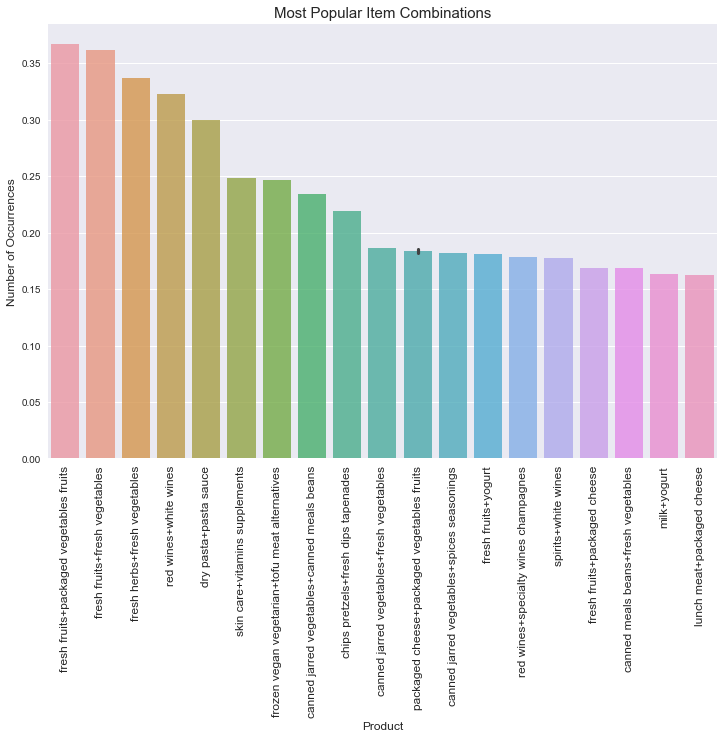

In [163]:
plt.figure(figsize=(12,8))
sns.barplot(df1['Combinations'], df1.quantities, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation='vertical',fontsize=12)
plt.title("Most Popular Item Combinations", fontsize=15)
plt.show()

This shows us what happens when two products But what do we do if we want to see how collections of items go? This only tells us about individual items. Let's give that a look